<a href="https://colab.research.google.com/github/avk1943/MS-Project/blob/main/MS_Code_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparing Data Loaders


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [ ]:

%cd /content/drive/Shared drives/Master Project/

with open('master_data_X.npy', 'rb') as f:
  X = np.load(f)

X.shape

/content/drive/Shared drives/Master Project


In [ ]:
with open('master_data_Y.npy', 'rb') as f:
  y = np.load(f)

y.shape

In [ ]:
X.dtype

In [ ]:
y.dtype

In [ ]:
X = np.float32(X)
X.dtype

In [ ]:
y = np.float32(y)
y.dtype

In [ ]:
import torch

In [ ]:
x_set = torch.from_numpy(X)

In [ ]:
x_set.size()

In [ ]:
#x_set = x_set.type(torch.LongTensor)

In [ ]:
#x_set = x_set.unsqueeze(1)
#x_set.size()

In [ ]:
#x_set = x_set.permute(0, 2, 1)

In [ ]:
y_set = torch.from_numpy(y)
y_set.size()

In [ ]:
#y_set = y_set.type(torch.LongTensor)

In [ ]:
from torch.utils.data import TensorDataset

In [ ]:
data_set = TensorDataset(x_set, y_set)

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
test_split = .3
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(x_set)
print("Dataset size:"+str(dataset_size))
indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)


In [ ]:
print(len(train_indices))

In [ ]:
print(len(test_indices))

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
batch_size = 8
train_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size,
                                           sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size,
                                                sampler=test_sampler)

# Basic SNN Model with more control

In [ ]:
!pip install snntorch --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 2.2 MB/s eta 0:00:00


In [ ]:
import torch, torch.nn as nn
import snntorch as snn

In [ ]:
#batch_size = 128
#data_path='/data/mnist'
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
import torch.nn.functional as F

# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        num_inputs = 30000
        num_hidden = 300
        num_outputs = 3
        #spike_grad = surrogate.fast_sigmoid()

        # global decay rate for all leaky neurons in layer 1
        beta1 = 0.9
        # independent decay rate for each leaky neuron in layer 2: [0, 1)
        beta2 = torch.rand((num_outputs), dtype = torch.float) #.to(device)

        # Init layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta1, learn_beta=True)
        #self.double()
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta2, learn_beta=True)
        #self.double()

    def forward(self, x):

        # reset hidden states and outputs at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x.flatten(1))
            #print(x.flatten(1).size())
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec), torch.stack(mem2_rec)

# Load the network onto CUDA if available
net = Net().to(device)

In [ ]:
import snntorch.functional as SF

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=2e-3, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate=0.7, incorrect_rate=0.3)
#SF.ce_count_loss()
#SF.mse_count_loss(correct_rate=0.6, incorrect_rate=0.4)

num_epochs = 1
num_steps = 10  # run for 25 time steps

loss_hist = []
acc_hist = []

# training loop
for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(train_loader)):
        data = data.to(device)
        targets = targets.to(device)

        net.train()
        spk_rec, _ = net(data)
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # print every 25 iterations
        if i % 25 == 0:
          net.eval()
          print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")

          # check accuracy on a single batch
          acc = SF.accuracy_rate(spk_rec, targets)
          acc_hist.append(acc)
          print(f"Accuracy: {acc * 100:.2f}%\n")

        # uncomment for faster termination
        # if i == 150:
        #     break


Epoch 0, Iteration 0 
Train Loss: 2.16
Accuracy: 50.00%

Epoch 0, Iteration 25 
Train Loss: 2.00
Accuracy: 25.00%

Epoch 0, Iteration 50 
Train Loss: 2.12
Accuracy: 37.50%

Epoch 0, Iteration 75 
Train Loss: 1.39
Accuracy: 37.50%

Epoch 0, Iteration 100 
Train Loss: 1.62
Accuracy: 12.50%

Epoch 0, Iteration 125 
Train Loss: 1.36
Accuracy: 37.50%

Epoch 0, Iteration 150 
Train Loss: 0.65
Accuracy: 75.00%

Epoch 0, Iteration 175 
Train Loss: 0.74
Accuracy: 50.00%

Epoch 0, Iteration 200 
Train Loss: 0.77
Accuracy: 25.00%

Epoch 0, Iteration 225 
Train Loss: 0.80
Accuracy: 50.00%

Epoch 0, Iteration 250 
Train Loss: 0.54
Accuracy: 37.50%

Epoch 0, Iteration 275 
Train Loss: 0.80
Accuracy: 50.00%

Epoch 0, Iteration 300 
Train Loss: 0.39
Accuracy: 62.50%

Epoch 0, Iteration 325 
Train Loss: 0.72
Accuracy: 12.50%

Epoch 0, Iteration 350 
Train Loss: 0.47
Accuracy: 50.00%

Epoch 0, Iteration 375 
Train Loss: 0.31
Accuracy: 62.50%

Epoch 0, Iteration 400 
Train Loss: 0.64
Accuracy: 37.50%

Ep

In [ ]:
print(f"Trained decay rate of the first layer:")
print(net.lif1.beta)

print(f"Trained decay rates of the second layer: {net.lif2.beta}")

Trained decay rate of the first layer:
Parameter containing:
tensor(0.8183, requires_grad=True)
Trained decay rates of the second layer: Parameter containing:
tensor([0.8946, 0.8081, 0.8503], requires_grad=True)


In [ ]:
def test_accuracy(data_loader, net, num_steps):
  with torch.no_grad():
    total = 0
    acc = 0
    net.eval()

    data_loader = iter(data_loader)
    for data, targets in data_loader:
      data = data.to(device)
      targets = targets.to(device)
      spk_rec, _ = net(data)

      acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
      total += spk_rec.size(1)

  return acc/total

In [ ]:
print(f"Test set accuracy: {test_accuracy(test_loader, net, num_steps)*100:.3f}%")

Test set accuracy: 54.699%


# Preparing Data Loaders for CE


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [3]:

%cd /content/drive/Shared drives/Master Project/

with open('master_data_X.npy', 'rb') as f:
  X = np.load(f)

X.shape

/content/drive/Shared drives/Master Project


(18588, 30, 1000)

In [4]:
with open('master_data_Y.npy', 'rb') as f:
  y = np.load(f)

y.shape

(18588,)

In [5]:
X.dtype

dtype('float64')

In [6]:
y.dtype

dtype('int64')

In [7]:
#X = np.int_(X)
X = np.float32(X)
X.dtype

dtype('float32')

In [8]:
y = np.float32(y)
#y = np.int_(y)
y.dtype

dtype('float32')

In [9]:
import torch

In [10]:
x_set = torch.from_numpy(X)

In [11]:
x_set.size()

torch.Size([18588, 30, 1000])

In [12]:
x_set.type()

'torch.FloatTensor'

In [13]:
#x_set = x_set.type(torch.LongTensor)
#print(type(x_set))

In [14]:
#x_set = x_set.unsqueeze(1)
#x_set.size()

In [15]:
#x_set = x_set.permute(0, 2, 1)

In [16]:
y_set = torch.from_numpy(y)
y_set.size()

torch.Size([18588])

In [17]:
y_set.type()

'torch.FloatTensor'

In [18]:
y_set = y_set.type(torch.LongTensor)
y_set.type()

'torch.LongTensor'

In [19]:
from torch.utils.data import TensorDataset

In [20]:
data_set = TensorDataset(x_set, y_set)

In [21]:
from torch.utils.data.sampler import SubsetRandomSampler

In [22]:
test_split = .3
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(x_set)
print("Dataset size:"+str(dataset_size))
indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)


Dataset size:18588


In [23]:
print(len(train_indices))

13012


In [24]:
print(len(test_indices))

5576


In [25]:
from torch.utils.data import DataLoader

In [26]:
batch_size = 1
train_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size,
                                           sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size,
                                                sampler=test_sampler)

# SNN model with CE

In [27]:
!pip install snntorch --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 3.2 MB/s eta 0:00:00


In [28]:
import torch, torch.nn as nn
import snntorch as snn
import torch.nn.functional as F
import snntorch.functional as SF

In [29]:
#batch_size = 128
#data_path='/data/mnist'
dtype=torch.long
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [30]:
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()

    beta = 0.9

    self.conv1 = nn.Conv2d(1, 8, 5, padding="same")
    self.lif1 = snn.Leaky(beta=beta)
    self.mp1 = nn.MaxPool2d(2)

    self.conv2 = nn.Conv2d(8, 1, 5, padding="same")
    self.lif2 = snn.Leaky(beta=beta)
    self.mp2 = nn.MaxPool2d(2)

    self.fc = nn.Linear(1750, 3)
    self.lif3 = snn.Leaky(beta=beta)
    #self.to(torch.long)

  def forward(self, x):

        # Initialize hidden states at t=0
    mem1 = self.lif1.init_leaky()
    mem2 = self.lif2.init_leaky()
    mem3 = self.lif3.init_leaky()

        # Record the final layer
    spk3_rec = []
    mem3_rec = []

        # time-loop
    for step in range(num_steps):
      cur1 = self.conv1(x)
      spk1, mem1 = self.lif1(self.mp1(cur1), mem1)
      cur2 = self.conv2(spk1)
      spk2, mem2 = self.lif2(self.mp2(cur2), mem2)
      cur3 = self.fc(spk2.flatten(1))
      spk3, mem3 = self.lif3(cur3, mem3)

      spk3_rec.append(spk3)
      mem3_rec.append(mem3)
    return torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0)

convnet = ConvNet().to(device)




In [31]:
loss = SF.ce_rate_loss()
optimizer = torch.optim.Adam(convnet.parameters(), lr=1e-2, betas=(0.9, 0.999))

In [32]:
num_epochs = 1
num_steps = 10 #10
loss_hist = []
acc_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        convnet.train()
        spk_rec, _ = convnet(data)
        #print(spk_rec)
        #print(counter)

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        #print(len(spk_rec.sum(0)))
        #print(torch.sum(spk_rec, 1))
        #print(targets.size())
        #print(torch.sum(spk_rec.sum(0), (1)).size())
        #print(spk_rec.sum(1))
        #print(spk_rec.sum(2))


        #loss_val = loss(spk_rec.sum(0), targets)
        #loss_val = loss(torch.sum(spk_rec.sum(0), (1)), targets)
        loss_val = loss(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

         # Store loss history for future plotting
        loss_hist.append(loss_val.item())
        acc = SF.accuracy_rate(spk_rec, targets)
        acc_hist.append(acc)

        # Print train/test loss/accuracy
        if counter % 10 == 0:
            print(f"Iteration: {counter} \t Train Loss: {loss_val.item()} \t Accuracy: {acc * 100:.2f}")
        counter += 1

        #if counter == 100:
        #  break




Iteration: 0 	 Train Loss: 1.0891789197921753 	 Accuracy: 100.00
Iteration: 10 	 Train Loss: 1.5514448881149292 	 Accuracy: 0.00
Iteration: 20 	 Train Loss: 0.5514448285102844 	 Accuracy: 100.00
Iteration: 30 	 Train Loss: 0.5514448285102844 	 Accuracy: 100.00
Iteration: 40 	 Train Loss: 0.5514448285102844 	 Accuracy: 100.00
Iteration: 50 	 Train Loss: 0.5514448285102844 	 Accuracy: 100.00
Iteration: 60 	 Train Loss: 0.5514448285102844 	 Accuracy: 100.00
Iteration: 70 	 Train Loss: 1.5514448881149292 	 Accuracy: 0.00
Iteration: 80 	 Train Loss: 0.5514448285102844 	 Accuracy: 100.00
Iteration: 90 	 Train Loss: 0.5514448285102844 	 Accuracy: 100.00
Iteration: 100 	 Train Loss: 0.5514448285102844 	 Accuracy: 100.00
Iteration: 110 	 Train Loss: 0.5514448285102844 	 Accuracy: 100.00
Iteration: 120 	 Train Loss: 0.5514448285102844 	 Accuracy: 100.00
Iteration: 130 	 Train Loss: 0.5514448285102844 	 Accuracy: 100.00
Iteration: 140 	 Train Loss: 1.5514448881149292 	 Accuracy: 0.00
Iteration: 1

In [35]:
print(len(acc_hist))

13012


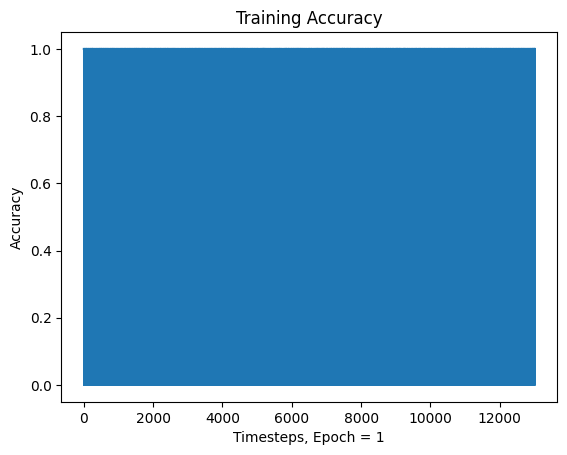

In [41]:
# Plot Training Accuracy
fig = plt.figure(facecolor="w")
plt.plot(acc_hist)
plt.title("Training Accuracy")
plt.xlabel("Timesteps, Epoch = 1")
plt.ylabel("Accuracy")
plt.show()

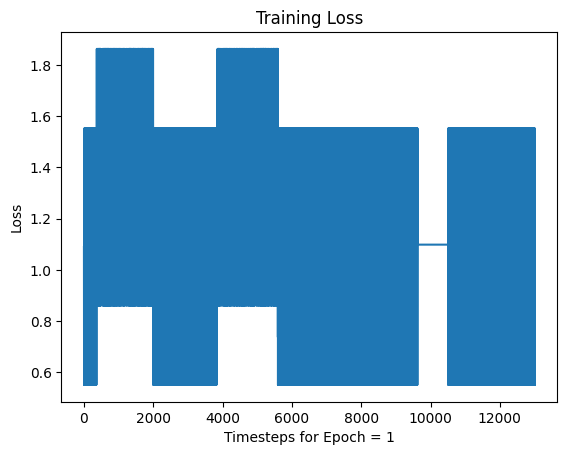

In [40]:
#Plot Training Loss
fig = plt.figure(facecolor="w")
plt.plot(loss_hist)
plt.title("Training Loss")
plt.xlabel("Timesteps for Epoch = 1")
plt.ylabel("Loss")
plt.show()

In [36]:
def measure_accuracy(model, dataloader):
  with torch.no_grad():
    model.eval()
    running_length = 0
    running_accuracy = 0

    for data, targets in iter(dataloader):
      data = data.to(device)
      targets = targets.to(device)

      # forward-pass
      spk_rec, _ = model(data)
      spike_count = spk_rec.sum(0)
      _, max_spike = spike_count.max(1)

      # correct classes for one batch
      num_correct = (max_spike == targets).sum()

      # total accuracy
      running_length += len(targets)
      running_accuracy += num_correct

    accuracy = (running_accuracy / running_length)

    return accuracy.item()


In [37]:
print(f"ConvNet Accuracy: {measure_accuracy(convnet, test_loader)}")

ConvNet Accuracy: 0.547345757484436
